### Step 0.  Import Python libraries

In [1]:
import pandas as pd
import numpy as np
import math
import time
import csv
import matplotlib.pyplot as plt
from mpl_axes_aligner import align
plt.style.use('ggplot')
import seaborn as sns

### Step 1. Data Collection

#### A.  The first set of timelines are from July 16, 2021.

https://docs.google.com/drawings/d/1Q1W_c9e0uouu30MFqw4zzxtH_wG5tc0tAZ0G2MXPle4/edit?usp=sharing

https://docs.google.com/drawings/d/1jOmP9gRJUvGIbUJzMJfDED5OGx_5VZDsc_3TdUCClfk/edit?usp=sharing

https://docs.google.com/drawings/d/1CThvvDMV54MhkbpAeKU0L5dKLNPTXNeTk4oL4LIyUME/edit?usp=sharing

https://docs.google.com/drawings/d/1vAtMxbGu0-UHqLWSXL3l5P_MeVNiQILI6E60HAfIjX0/edit?usp=sharing

https://docs.google.com/drawings/d/1mHnZ7ArS3rdXWzcP4Y_olGkpK3eZMNMsja5ce3x4PTo/edit?usp=sharing


#### B.  Manually translating these to a Google Sheet

https://docs.google.com/spreadsheets/d/1gf-2D6G_DmxV5sY3gTIvXwj94AAM6BRhC0jAhKhWcDk/edit?usp=sharing
    

#### C. Read Google Sheet CSV into Pandas Price History dataframe

In [2]:
def split_list(string):
    if pd.isnull(string):
        return string
    lis = string.split(',')
    if len(lis) == 4:
        return lis
    elif len(lis) == 1:
        lis = pd.to_numeric(lis[0])
        return lis
    else:
        print ("ERROR: OHLC list has %d prices.  Expected 4: %s" % (len(lis), lis))
        return "ERROR"

In [4]:
PriceHistory = pd.read_csv('Data/Price History July 16 - OHLC.csv', 
                           parse_dates=['Date'], infer_datetime_format=True)
PriceHistory['Bid'] = PriceHistory['Bid'].apply(lambda x: split_list(x))
PriceHistory['Ask'] = PriceHistory['Ask'].apply(lambda x: split_list(x))
PriceHistory.UL.fillna(PriceHistory.UL.iloc[0], inplace=True)
PriceHistory.Date.fillna(PriceHistory.Date.iloc[0], inplace=True)
PriceHistory.TimeToExp.astype(int)
PriceHistory.info()
print(PriceHistory.describe())
print(PriceHistory.head(10))
PriceHistory.to_csv('Data/TabulatedPriceHistory_071621.csv', na_rep='NaN', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   UL          10 non-null     object        
 1   Date        10 non-null     datetime64[ns]
 2   Expiration  10 non-null     object        
 3   Strike      10 non-null     float64       
 4   PriceTime   10 non-null     object        
 5   TimeToExp   10 non-null     int64         
 6   Bid         10 non-null     object        
 7   Ask         10 non-null     object        
 8   Horizon     2 non-null      object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(6)
memory usage: 848.0+ bytes
        Strike  TimeToExp
count    10.00   10.00000
mean   4332.75    4.50000
std       0.00    3.02765
min    4332.75    0.00000
25%    4332.75    2.25000
50%    4332.75    4.50000
75%    4332.75    6.75000
max    4332.75    9.00000
       UL       Date Expiration   Strike PriceTime 

### Step 2. Trading Model Development / Scenario Data Construction

In [5]:
## Define a class to transport information from PriceHistory DF to our potential trades
class EntryPoint():
    def __init__(self, price, timetogo, side, series):
        self.price = price
        self.ttexp = timetogo
        self.side  = side
        self.series= series   ## A tuple of the 4 identifying columns for this option series
        self.investment = 0
        
    def invested(self):
        if not self.investment:
            if self.side=='long':
                self.investment = self.price + 1
            else:
                self.investment = 101 - self.price
        return self.investment

In [6]:
## Prototype Trading Model here
### Find candidate entry points in the PriceHistory

### These parameters are moved into the find() signatures as defaults.
#earliest_entry = 9   ## for 20 minute options, we won't start before 9 minutes to expiration
#entry_deadline = 0   ## for the Buy and Hope, we'll go inside a minute if we have it, for others it's outside a minute.
#min_buy = 55              ## Research buys between 55 and 80, inclusive
#max_buy = 80
#max_sale = 45             ## Research sales between 45 and 20, inclusive
#min_sale = 20

## Just find all candidate entries within our time frame and price ranges
## Please note that since I am using time to expiration as my time dimension, time will be backwards.  9 comes before 8, etc.
## And to make time inequalities work easily and they will always be less than an hour, I am just using integer times.
def find_candidate_long_entry_points(optid, df, earliest_entry=9, entry_deadline=0, min_buy=55, max_buy=80):
    long_entries = []
    dft = df[(df.TimeToExp <= earliest_entry) & (df.TimeToExp > entry_deadline)]

    for i, row in dft.iterrows():    
        for buy in range(max(math.ceil(float(row.Ask[2])), min_buy), min(math.floor(float(row.Ask[1])), max_buy) + 1):
            entry = EntryPoint(buy, row.TimeToExp, 'long', optid)
            long_entries.append(entry)
    return long_entries

def find_candidate_short_entry_points(optid, df, earliest_entry=9, entry_deadline=0, max_sale=45, min_sale=20):
    short_entries = []
    dft = df[(df.TimeToExp <= earliest_entry) & (df.TimeToExp > entry_deadline)]
    
    for i, row in dft.iterrows():
        for sale in range(max(math.ceil(float(row.Bid[2])), min_sale), min(math.floor(float(row.Bid[1])), max_sale) + 1):
            entry = EntryPoint(sale, row.TimeToExp, 'short', optid)
            short_entries.append(entry)
    return short_entries


def find_longshot_buy_points(optid, df, earliest_entry=9, entry_deadline=0, min_buy=20, max_buy=45):
    longshot_buys = []
    dft = df[(df.TimeToExp <= earliest_entry) & (df.TimeToExp > entry_deadline)]
    
    for i, row in dft.iterrows():    
        for buy in range(max(math.ceil(float(row.Ask[2])), min_buy), min(math.floor(float(row.Ask[1])), max_buy) + 1):
            entry = EntryPoint(buy, row.TimeToExp, 'long', optid)
            longshot_buys.append(entry)
    return longshot_buys

def find_longshot_sell_points(optid, df, earliest_entry=9, entry_deadline=0, max_sale=80, min_sale=55):
    longshot_sales = []
    dft = df[(df.TimeToExp <= earliest_entry) & (df.TimeToExp > entry_deadline)]
    
    for i, row in dft.iterrows():
        for sale in range(max(math.ceil(float(row.Bid[2])), min_sale), min(math.floor(float(row.Bid[1])), max_sale) + 1):
            entry = EntryPoint(sale, row.TimeToExp, 'short', optid)
            longshot_sales.append(entry)
    return longshot_sales


In [7]:
def makePotentialRow(entry, exit, optid, pl_exits=None):
    xprice = exit[0]
    if entry.side=='long':
        fee = 2 if xprice > 0 else 1
        profitloss = xprice - entry.price - fee
    else:
        fee = 2 if xprice < 100 else 1
        profitloss = entry.price - xprice - fee
        
    preturn = 100 * profitloss / entry.invested()
    
    if pl_exits:
        result = {'OptSeries':optid, 'Side':entry.side, 'Exits':pl_exits, 'EntryTTX':entry.ttexp, 'EntryPrice':entry.price, 'Invested':entry.invested(), \
                  'ExitTTX':exit[1], 'ExitPrice':xprice, 'ProfitLoss':profitloss, '%Return':preturn }
    else:
        result = {'OptSeries':optid, 'Side':entry.side, 'EntryTTX':entry.ttexp, 'EntryPrice':entry.price, 'Invested':entry.invested(), \
                  'ExitTTX':exit[1], 'ExitPrice':xprice, 'ProfitLoss':profitloss, '%Return':preturn }
    
    return result

In [8]:
##########
#   Several strategies will be implemented here.  
##  Each will search the PriceHistory data according to its own strategy to find the first exit point that qualifies.
##########

## Buy and Hope strategy function
def buy_and_hope(entries, optid, OH):
    results = []
    for en in entries:        
        if en.side == 'long':
            exitPoint = (OH[OH.Horizon == 'Expy']['Bid'].to_list()[0],
                     OH[OH.Horizon == 'Expy']['TimeToExp'].to_list()[0])
        else:
            exitPoint = (OH[OH.Horizon == 'Expy']['Ask'].to_list()[0],
                     OH[OH.Horizon == 'Expy']['TimeToExp'].to_list()[0])

        results.append(makePotentialRow(en, exitPoint, optid))
    return results

In [9]:
def longshot_hope(entries, optid, OH):
    return buy_and_hope(entries, optid, OH)

In [10]:
## Exit at fixed profit or loss price points
def touch_exits(entries, optid, OH, exit_lists):
    results = []
    profit_exits, loss_exits = exit_lists
    print ("px ", profit_exits, "lx ", loss_exits)
    
    for px in profit_exits:
        for lx in loss_exits:
            for en in entries:
                if en.side == 'long':
                    for t in range(en.ttexp, 0, -1):          ## Have to sell a long position at the Bid.
                        bid = OH[(OH.TimeToExp == t)]['Bid'].tolist()[0]  ## Check the Bid OHLC range or scalar expiry price at ttgo t
                        #print("t is ", t, "bid is ", bid)
                        if t == 0:
                            results.append(makePotentialRow(en, (bid, 0), optid, (px, lx)))
                        else:     ## We are trying to sell if the Bid High (OHLC) touches (is >=) our profit_exit.
                            if (float(bid[1]) >= px):
                                results.append(makePotentialRow(en, (px, t), optid, (px, lx)))
                                break
                            elif (float(bid[2]) <= lx):  ## Cut losses, sell if Bid Low touches our loss_exit.  
                                results.append(makePotentialRow(en, (lx, t), optid, (px, lx)))
                                break
                else:     ## en.side == 'short':
                    for t in range(en.ttexp, 0, -1):
                        ask = OH[(OH.TimeToExp == t)]['Ask'].tolist()[0]  ## Check the Ask OHLC range or scalar expiry price at ttgo t
                        if t == 0:
                            results.append(makePotentialRow(en, (ask, 0), optid, (px, lx)))
                        else:     ## We are trying to buy if the Ask Low (OHLC) touches (is <=) our profit_exit.
                            if (float(ask[2]) <= px):
                                results.append(makePotentialRow(en, (px, t), optid, (px, lx)))
                                break
                            elif (float(ask[1]) >= lx):  ## Cut losses, buyback if Ask High touches our loss_exit.  
                                results.append(makePotentialRow(en, (lx, t), optid, (px, lx)))
                                break
    return results

In [11]:
def find_exits(entries, strategy, optid, OH, parameters=None):
    if parameters:
        results = strategy(entries, optid, OH, parameters)
    else:
        results = strategy(entries, optid, OH)
    return results

In [12]:
def tabulateResults(longs, shorts):
    return pd.DataFrame(longs + shorts)

In [13]:
## Plot results -- P or L and % Return on twin Y Axes 
def plotResults(Results, title, zero=0.5, legendloc='upper center'):
    plt.style.use('seaborn')
    plt.title(title, size=20)
    profit = Results.ProfitLoss > 0
    
    p1 = sns.lineplot(data=Results, y='ProfitLoss', x='EntryPrice', legend='brief',\
            style='Side', markers=('o','X'), hue=profit, palette=['r','g'],\
            size_norm=(-100,100)    )
    p1.set_xlabel("Entry Price", size=14)
    p1.set_ylabel("Profit or Loss  ($ / contract)", size=14)
    p1.legend(loc=legendloc, labels = [ 'Short Position', 'Long Position'])
    p1.yaxis.get_label().set_color('r')

    ax2 = p1.twinx()
    sns.lineplot(data=Results, y='%Return', x='EntryPrice', legend=None,ax=ax2,\
            style='Side', markers=('o','X'), hue=profit, palette=['orange','lime'],\
            sizes=(-100,100)    )
    ax2.set_ylabel("% Return", size=14)
    ax2.yaxis.get_label().set_color('orange')
        
    # Align the plotting origin of two y axes
    align.yaxes(p1, 0.0, ax2, 0.0, zero)

    plt.show()

In [21]:
## Plot Choices versus returns
def plotExpectations(Results, title, zero=0.5, legendloc='upper center'):
    plt.style.use('seaborn')
    profit = Results.ProfitLoss > 0
    porl = 'gain' if Expect['ProfitLoss'].sum() > 0 else 'lose'
    title += '\nExpect to %s %.2f per contract.' % (porl, round(Expect['ProfitLoss'].sum(), 2))

    plt.title(title, size=18)
    
    p1 = sns.scatterplot(data=Results, y='ExitPrice', x='EntryPrice', legend='brief',\
            style='Side', markers=('X','o'), hue=profit, palette=['r','g'],\
                        size='ProfitLoss')
    p1.set_xlabel("Entry Price", size=14)
    p1.set_ylabel("Exit Price", size=14)
    p1.legend(loc=legendloc, labels = ['Short Position', 'Long Position'])

    #ax2 = p1.twinx()
    #sns.lineplot(data=Results, y='%Return', x='EntryPrice', legend=None,ax=ax2,\
    #        style='Side', markers=('o','X'),hue=profit, palette=['orange','lime'],\
    #        sizes=(-100,100)    )
    #ax2.set_ylabel("% Return", size=14)
    #ax2.yaxis.get_label().set_color('orange')
        
    # Align the plotting origin of two y axes
    #align.yaxes(p1, 0.0, ax2, 0.0, zero)

    plt.show()

In [15]:
####################
### The "main" to run several strategies begins here.
###  First, we must batch up the data by option series (UL, Date, Expiration, Strike) to search through each separately
###  Then, since this is a notebook and not a regular program in an IDE, I'll set this up to
###  iterate over the data for each strategy.  This way I can add or experiment with each strategy at will.

# This groups the price data by Option Series (a VERY important step in the scheme of things)
seriees = PriceHistory.groupby(['UL','Date','Expiration','Strike'])  
optid = []
OptionHist = []

for series in seriees:
    date = series[0][1].date().strftime("%Y-%m-%d")
    opt_series = (series[0][0], date, series[0][2], series[0][3])

    optid.append(opt_series)
    OptionHist.append(series[1])
    
print ("We have prices for this list of options:\n", optid)

We have prices for this list of options:
 [('US 500', '2021-07-16', '14:20', 4332.75)]


('US 500', '2021-07-16', '14:20', 4332.75)
       UL       Date Expiration   Strike PriceTime  TimeToExp  \
0  US 500 2021-07-16      14:20  4332.75     14:11          9   
1  US 500 2021-07-16      14:20  4332.75     14:12          8   
2  US 500 2021-07-16      14:20  4332.75     14:13          7   
3  US 500 2021-07-16      14:20  4332.75     14:14          6   
4  US 500 2021-07-16      14:20  4332.75     14:15          5   
5  US 500 2021-07-16      14:20  4332.75     14:16          4   
6  US 500 2021-07-16      14:20  4332.75     14:17          3   
7  US 500 2021-07-16      14:20  4332.75     14:18          2   
8  US 500 2021-07-16      14:20  4332.75     14:19          1   
9  US 500 2021-07-16      14:20  4332.75     14:20          0   

                      Bid                       Ask Horizon  
0   [72.5,  75,  70,  70]       [74,  77,  71,  71]     NaN  
1     [70,  73,  48,  55]     [72,  75.5,  51,  59]     NaN  
2   [54,  59.5,  30,  42]       [59,  62,  35,  47]    

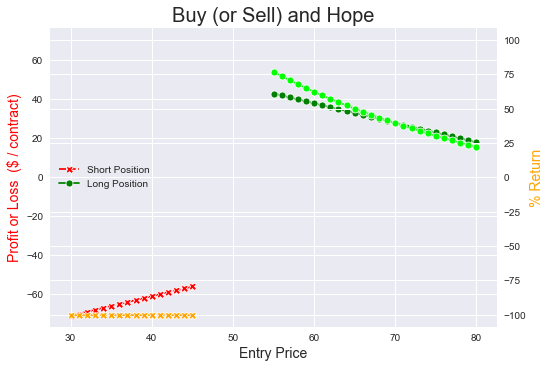

In [16]:
strategy = buy_and_hope

for o in range(len(optid)):
    print (optid[o])
    print (OptionHist[o])
    
    ## Find long and short entry points
    buy_list = find_candidate_long_entry_points(optid[o], OptionHist[o])
    sell_list = find_candidate_short_entry_points(optid[o], OptionHist[o])

    long_results = find_exits(buy_list, strategy, optid[o], OptionHist[o])
    short_results = find_exits(sell_list, strategy, optid[o], OptionHist[o])
    BH_Results = tabulateResults(long_results, short_results)
    BH_Results.to_csv('Data/out/BuyandHope_716_1420_4332.csv', na_rep='NaN')

    print (BH_Results)
    plotResults(BH_Results, 'Buy (or Sell) and Hope', legendloc='center left')


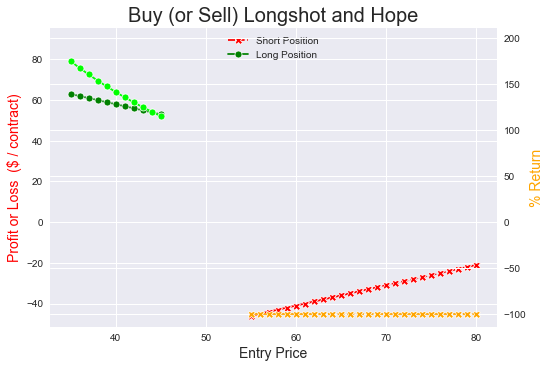

In [17]:
strategy = longshot_hope
for o in range(len(optid)):
    
    long_results = find_exits(find_longshot_buy_points(optid[o], OptionHist[o]), strategy, optid[o], OptionHist[o])
    short_results = find_exits(find_longshot_sell_points(optid[o], OptionHist[o]), strategy, optid[o], OptionHist[o])
    LS_Results = tabulateResults(long_results, short_results)
    LS_Results.to_csv('Data/out/LongshotHope_716_1420_4332.csv', na_rep='NaN')

    plotResults(LS_Results, 'Buy (or Sell) Longshot and Hope', 0.35, 'upper center')

px  [75, 80, 85, 90, 95] lx  [50, 40]
px  [25, 20, 15, 10, 5] lx  [50, 60]


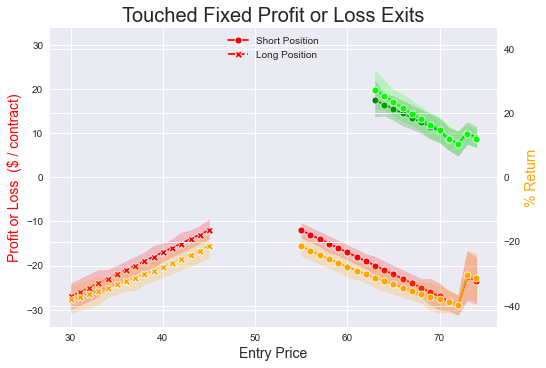

    EntryPrice  ExitPrice   Side  ProfitLoss
0           30         50  short   -0.785714
1           31         50  short   -0.750000
2           32         50  short   -0.714286
3           33         50  short   -0.678571
4           34         50  short   -1.285714
5           35         50  short   -1.214286
6           36         50  short   -1.142857
7           37         50  short   -1.071429
8           38         50  short   -1.000000
9           39         50  short   -0.928571
10          40         50  short   -0.857143
11          41         50  short   -0.785714
12          42         50  short   -0.714286
13          43         50  short   -0.642857
14          44         50  short   -0.571429
15          45         50  short   -0.500000 
With exits (5, 50), we expect to lose -13.64 on each position.
    EntryPrice  ExitPrice   Side  ProfitLoss
0           30         60  short   -1.142857
1           31         60  short   -1.107143
2           32         60  short   -

31          74         75  long   -0.043478 
With exits (75, 50), we expect to lose -7.29 on each position.
    EntryPrice  ExitPrice  Side  ProfitLoss
0           55         40  long   -0.739130
1           56         40  long   -0.782609
2           57         40  long   -0.826087
3           58         40  long   -0.869565
4           59         40  long   -0.913043
5           60         40  long   -0.956522
6           61         40  long   -1.000000
7           62         40  long   -1.043478
8           63         40  long   -0.724638
9           63         80  long    0.217391
10          64         40  long   -0.753623
11          64         80  long    0.405797
12          65         40  long   -0.782609
13          65         80  long    0.376812
14          66         40  long   -0.811594
15          66         80  long    0.347826
16          67         40  long   -0.840580
17          67         80  long    0.318841
18          68         40  long   -0.869565
19          

19          74         40  long   -1.565217 
With exits (95, 40), we expect to lose -25.24 on each position.
    EntryPrice  ExitPrice  Side  ProfitLoss
0           55         50  long   -0.456522
1           56         50  long   -0.521739
2           57         50  long   -0.586957
3           58         50  long   -0.652174
4           59         50  long   -0.717391
5           60         50  long   -0.782609
6           61         50  long   -0.847826
7           62         50  long   -0.913043
8           63         50  long   -0.652174
9           64         50  long   -0.695652
10          65         50  long   -0.739130
11          66         50  long   -0.782609
12          67         50  long   -0.826087
13          68         50  long   -0.869565
14          69         50  long   -0.456522
15          70         50  long   -0.478261
16          71         50  long   -1.000000
17          72         50  long   -1.043478
18          73         50  long   -1.086957
19         

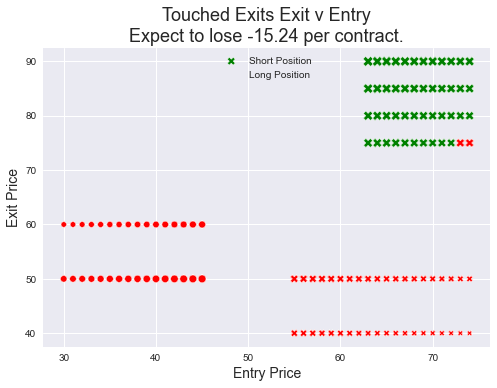

In [25]:
strategy = touch_exits

for o in range(len(optid)):
    ## Find long and short entry points
    buy_list = find_candidate_long_entry_points(optid[o], OptionHist[o], min_buy=55, max_buy=74)
    sell_list = find_candidate_short_entry_points(optid[o], OptionHist[o], max_sale=45, min_sale=26)
    
    long_results = find_exits(buy_list, strategy, optid[o], OptionHist[o], ([75,80,85,90,95],[50,40]))
    short_results = find_exits(sell_list, strategy, optid[o], OptionHist[o], ([25,20,15,10,5],[50,60]))
    TE_Results = tabulateResults(long_results, short_results)
    TE_Results.to_csv('Data/out/TouchExits_716_1420_4332.csv', na_rep='NaN')
    
    exit_choices = TE_Results.groupby(['Exits'])
    
    plotResults(TE_Results, 'Touched Fixed Profit or Loss Exits')
    for choice, results in exit_choices:
        total_points = len(results)
        Expected_PL = results.groupby(['EntryPrice','ExitPrice','Side'])['ProfitLoss'].sum()/total_points
        Expect = pd.DataFrame(Expected_PL)
        Expect.reset_index(inplace=True)
        porl = 'gain' if Expect['ProfitLoss'].sum() > 0 else 'lose'

        print(Expect, '\nWith exits %s, we expect to %s %.2f on each position.' % \
              (choice, porl, round(Expect['ProfitLoss'].sum(), 2)))
        filename = 'Data/out/TouchExitExpectation_%d_%d.csv' % (choice[0], choice[1])
        Expect.to_csv(filename, na_rep='NaN')
        
    plotExpectations(TE_Results, 'Touched Exits Exit v Entry')


### Step 3. Exploratory Data Analysis

#### A. Entry point return statistics

In [245]:
print(BH_Results.groupby(['EntryPrice']).mean()['ProfitLoss'])
print(BH_Results.groupby(['EntryPrice']).sum()['ProfitLoss'])
print(BH_Results.groupby(['EntryPrice']).mean()['%Return'])


EntryPrice
30   -71.0
31   -70.0
32   -69.0
33   -68.0
34   -67.0
35   -66.0
36   -65.0
37   -64.0
38   -63.0
39   -62.0
40   -61.0
41   -60.0
42   -59.0
43   -58.0
44   -57.0
45   -56.0
55    43.0
56    42.0
57    41.0
58    40.0
59    39.0
60    38.0
61    37.0
62    36.0
63    35.0
64    34.0
65    33.0
66    32.0
67    31.0
68    30.0
69    29.0
70    28.0
71    27.0
72    26.0
73    25.0
74    24.0
75    23.0
76    22.0
77    21.0
78    20.0
79    19.0
80    18.0
Name: ProfitLoss, dtype: float64
EntryPrice
30    -71
31    -70
32    -69
33    -68
34   -134
35   -132
36   -130
37   -128
38   -126
39   -124
40   -122
41   -120
42   -118
43   -116
44   -114
45   -112
55    129
56    126
57    123
58    120
59    117
60    114
61    111
62    108
63    105
64    136
65    132
66    128
67    124
68    120
69     87
70     84
71    108
72    104
73    100
74     96
75     92
76     66
77     63
78     40
79     38
80     36
Name: ProfitLoss, dtype: int64
EntryPrice
30   -100.000000
31  

#### B. 

### Step 4. Trading Model Logic

#### A. Scenarios in Potentials Table
Each unique UL-Date-Strike-Expiry tuple has its set of rows, in chronological order, that encompasses all possible trading scenarios given my selected list of potential exit prices.  If a trading algorithm exited at one of these points before expiration, then the rest of that set of rows would become moot.  

I will define a few alternative trading models and select the first actual exit under the logic of each model.  I will display and store the results under each model.

I will compare these results over entry points, time, and data from other trading days and expirations.  The statistics of these results will be used to select the best trading model.  Best will be defined by a combination of minimal losses and most reliable gains, to generate the largest reliable returns over a month.  Big gains with high variance will be avoided.

There are always trade-offs in trading.  If you pick an aggressive stop loss strategy, you will avoid big losses, but you will incur the opportunity cost of missing some profits when the price swings back in your favor.  If you dont use a stop loss, you won't have any opportunity costs, but you will often lose the whole investment in the position.

Trading Nadex binary options is considerably different than trading stocks and many other securities, including ordinary options, because they are always priced on the 0 to 100 scale and because time decay will take them down from 49 or up from 51 in the last few minutes.  This trading idea counts on that decay to take the time value away more often than not, as the option moves from trading like a linear security to trading in a binary fashion, with much uncertainty near 50 when the underlying is near the strike price.  The loss exits around 50 will be used to cut our losses if the price moves against us to the other side of 50 (bin option)/the strike price (underlying).

#### B. Determine the Entry Point

If we could count on the underlying price to never cross the strike price in the last x minutes, then we could just count on time decay always keeping the binary option price on the same side of 50.  Then we would just hold until expiration.  If we buy (sell) late enough, the odds are pretty good that this will happen, but when they are too good, the price runs away toward 90 and 100 (10 and 0).  That is, if you get in too late, your profit potential is limited, as the probability of loss moves toward 0.  Naturally.  Oh, and by the way, the amount at risk goes up when you enter closer to 100 or 0.

To keep uncertainty manageable, the entry point needs to be some distance away from 50.  Something like buying at 60 or selling at 40 is a good minimum.   However buying at 80 or above (selling at 20 or below) both decreases your profit potential (to \\$20 or 25\%) and increases your value at risk (\\$30 even if you always get out at 50, up to \\$80 if you don't).

A nice risk/reward profile can be had at buy 65 (sell 35), with a loss exit at 50, and a profit exit at 90 (10).  This yields a potential reward of \\$25 with a nominal risk of \\$15.  But we have to remember that if we dont get out at 50, the price can quickly move against us and take away most of that \\$65 investment.  Also, the transaction fees are \\$1 on both sides of every trade and profitable expiration.  So the true reward with this strategy is \\$23 with a risk of \\$17 to \\$27.

We have selected potential entry points of 25, 30, and 33-40 to sell at when the underlying is below the strike and 75, 70, and 67-60 to buy at when the underlying is above the strike.

We will find the best entry point in conjunction with finding the best profit taking strategy, after finding the best stop loss tactic.

#### C. Determine the Stop Loss Tactic

Tuning the loss exits and the profit exits together would cloud the picture on each side.  We will tune the loss exit while holding the profit exit constant at a representative strategy.  Namely sell for a profit at 90 (buy to close at 10).

In the Data Collection Plan, we already selected potential loss exit prices at 55, 50, 45, and 40 for long positions (45, 50, 55, and 60 for short positions).  We will run statistics to choose from among these.  My intuition tells me that 45 or 50 (55 or 50) will likely be the best points.

At this point we won't look at hysteresis or time at a price level on the stop loss exit side.  We will simply exit if the price ever reaches our exit point.

In [ ]:
### Trading price journey function

Potentials.groupby(['EntryPrice', 'UL', 'Date',''])
for index, row in EntryShorts.iterrows():
    